# SI: Anomalous Fibril Length Dependence on Amyloid Adsorption to Charged Interfaces

_Giulio Tesei, Erik Hellstrand, Sara Linse, Emma Sparr, Robert Vacha, and Mikael Lund_

## System Requirements
This Jupyter Notebook was originally run in MacOS 10.11 with `GCC 4.8`, `cmake`, `Python3`, `matplotlib`, `pandas` within the Anaconda environment. Contemporary Linux distributions such as Ubuntu 14.04 will also work.

In [488]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, shutil
from pathlib import Path
import mdtraj as md
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/lunarc/nobackup/users/gtesei00/AllFibrils_pf


## I. Metropolis Monte Carlo (MC) Simulations

### Download and build Faunus

To simulate the interaction of rigid fibrils with a charged, planar surface we use a custom MC program build within the [Faunus framework](http://github.com/mlund/faunus.git). The sections below will fetch the Faunus project and compile the appropriate version of the program.

In [1058]:
%%bash -s "$workdir"
module purge
module add GCC/6.2.0-2.27
module add CMake
cd $1

if [ ! -d "faunus" ]; then
  git clone https://github.com/mlund/faunus.git
  cd faunus
else
  cd faunus
fi

CXX=/sw/easybuild/software/Core/GCCcore/6.2.0/bin/g++ CC=/sw/easybuild/software/Core/GCCcore/6.2.0/bin/gcc cmake . -DENABLE_APPROXMATH=on -DCMAKE_BUILD_TYPE=Release -DMYPLAYGROUND=`pwd`/../mc/ #&>/dev/null
make r2s -j4
cd $1

-- Could NOT find Doxygen (missing:  DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /lunarc/nobackup/users/gtesei00/AllFibrils_pf/faunus
[ 33%] Built target xdrfile
[ 83%] Built target libfaunus
[100%] Built target r2s


......................................................................
  Faunus is running in Release mode recommended for production runs.
  For setting up simulations it is HIGHLY recommended to use Debug
  mode to enable run-time checks and assertions:

  -DCMAKE_BUILD_TYPE=RelWithDebInfo
**********************************************************************



### Create slurm submit script for cluster runs
This part is only for performing the calculations on a cluster, here assumed to use `slurm` for submitting jobs. Below you specify number of processers (`-N`), cores (`-n`) and wall time for each job to be submitted.

In [489]:
%%writefile mc/submit.sh
#!/bin/bash
#SBATCH -p snic
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -A snic2017-1-48
#
# job time, change for what your job requires 
#SBATCH -t 20:00:00
# 
# job name
#SBATCH -J 5kk3
#
# filenames stdout and stderr - customise, include %j
#SBATCH -o fibrils.out
#SBATCH -e fibrils.err

module purge
module add GCC/6.2.0-2.27
module add CMake

../../r2s > out

Overwriting mc/submit.sh


### Function to extract aggregate from long fibril structure
Peptides are ordered according to their position along the fibril axis. The N-terminal D is a neutral NTR bead, whereas the C-terminal A is a negatively charged CTR bead.

In [51]:
# t is the pdb file
# numpep is the number of peptides in the final aggregate
# peplen is the number of residues per peptide, e.g. 42 for Abeta1-42
# startres is the index of the starting residue, e.g. 17 for Abeta17-42
def masscenter(residue, xyz):
    ''' mass center of residue '''
    cm = [0,0,0] # residue mass center
    mw = 0       # residue mass
    for a in residue.atoms:
        cm = cm + a.element.mass * xyz[a.index]
        mw = mw + a.element.mass
    return cm/mw

def coarsegrain(t):
    ''' generates a CG version of trajectory (residue mass center level) '''
    cnt=0
    cgtop = md.Topology()       # new CG topology
    cgchain = cgtop.add_chain() # new CG chain
    cgxyz   = []                # new CG positions

    for i in t.top.residues: # add CG residues and atoms
        cgres = cgtop.add_residue(i.name, cgchain)
        atom = cgtop.add_atom(i.name, element=md.element.argon, residue=cgres)

    for aapos in t.xyz:      # coarse grain each frame
        cnt=cnt+1
        pos = []
        for res in t.top.residues:
            pos.append(masscenter(res, aapos))
        cgxyz.append( pos )

    return md.Trajectory(cgxyz, topology=cgtop, unitcell_lengths=t.unitcell_lengths, unitcell_angles=t.unitcell_angles)

def extract_agg(t, numpep, peplen, startres):
    t = coarsegrain(t)
    met = np.empty(0)
    for i in t.topology.atoms:
        if (i.name=='MET'):
            met = np.append(met, [i.index,t.xyz[0][i.index][2]])
    met = met.reshape((int(met.size/2),2))
    order = met[:,1].argsort()
    met = np.take(met, order, 0)
    if peplen == 40:
        first_z = (met[:,0]-peplen+6).astype(int)
    else:
        first_z = (met[:,0]-peplen+8).astype(int)
        
    cnt=0
    cgtop = md.Topology()       # new CG topology
    cgchain = cgtop.add_chain() # new CG chain
    cgxyz   = []                # new CG positions

    for i in first_z[int((first_z.size-numpep)/2):int((first_z.size+numpep)/2)]:
        cgres = cgtop.add_residue("NTR", cgchain)
        atom = cgtop.add_atom("NTR", element=md.element.argon, residue=cgres)
        # the N-term ASP is merged with NH3+ and is neutral
        cgxyz.append( t.xyz[0][i+startres-1][:] )
        for j in range(i+startres,i+peplen-1):
            cgres = cgtop.add_residue(t.top.atom(j).name, cgchain)
            atom = cgtop.add_atom(t.top.atom(j).name, element=md.element.argon, residue=cgres)
            cgxyz.append( t.xyz[0][j][:] )
        cgres = cgtop.add_residue("CTR", cgchain)
        atom = cgtop.add_atom("CTR", element=md.element.argon, residue=cgres)
        # the C-term ALA is merged with COO- and is negatively charged
        cgxyz.append( t.xyz[0][i+peplen-1][:] )

    return md.Trajectory(cgxyz, topology=cgtop, unitcell_lengths=t.unitcell_lengths, unitcell_angles=t.unitcell_angles)

### Create Input and run Monte Carlo simulation

This will generate all input for MC simulations as well as loop over the full parameter space.
In the inner loop you may specify if the jobs should be run locally (not recommended) or be submitted to a cluster, assuming you are running this Notebook from a cluster environment.

In [506]:
%cd $workdir

def mkinput():
    js = {
      "atomlist" : {
        "NTR"  :  { "q":charge_ntr,  "r":3.6, "mw":110 },
        "ASP"  :  { "q":-1, "r":3.6, "mw":110 },
        "CTR"  :  { "q":-1, "r":3.1, "mw":66 },
        "ALA"  :  { "q":0,  "r":3.1, "mw":66 },
        "GLU"  :  { "q":-1, "r":3.8, "mw":122 },
        "HIS"  :  { "q":0,  "r":3.9, "mw":130 },
        "TYR"  :  { "q":0,  "r":4.1, "mw":154 },
        "LYS"  :  { "q":1,  "r":3.7, "mw":116 },
        "CYS"  :  { "q":0,  "r":3.6, "mw":103 },
        "ARG"  :  { "q":1,  "r":4.0, "mw":144 },
        "ILE"  :  { "q":0,  "r":3.6, "mw":102 },
        "LEU"  :  { "q":0,  "r":3.6, "mw":102 },
        "MET"  :  { "q":0,  "r":3.8, "mw":122 },
        "PHE"  :  { "q":0,  "r":3.9, "mw":138 },
        "PRO"  :  { "q":0,  "r":3.4, "mw":90 },
        "TRP"  :  { "q":0,  "r":4.3, "mw":176 },
        "VAL"  :  { "q":0,  "r":3.4, "mw":90 },
        "SER"  :  { "q":0,  "r":3.3, "mw":82 },
        "THR"  :  { "q":0,  "r":3.5, "mw":94 },
        "ASN"  :  { "q":0,  "r":3.6, "mw":108 },
        "GLN"  :  { "q":0,  "r":3.8, "mw":120 },
        "GLY"  :  { "q":0,  "r":2.9, "mw":54 }
          },  
      "energy" : {
          "gouychapman" : { "qarea": qarea, "offset":3 },
          "nonbonded" : {
            "coulomb"  : { "epsr" : 78.54 },
            "ionicstrength": salt 
            },
          "penalty" : { 
                "xyz" : { "dir":"0 0 1", "first":"fibril", "bw1":1, "lo1":-len_z/4+min_dist, 
                         "hi1":len_z/2-min_dist, "f0":10, "scale":0.5, "update":1e4} 
            }  
          },
      "moves" : {
          "moltransrot"      : { "fibril" : { "dp":20, "dprot":6, "permol":True }  }
          },
      "moleculelist" : {
          "fibril" : { "Ninit":1, "structure":str(numpep)+".xyz" } 
          },
      "system" : {
          "temperature"  : 298,
          "geometry"   : { "length" : [2000, 2000, len_z] },
          "mcloop"       : { "macro":10, "micro": micro }
          },
      "analysis" : {
          "statefile" : { "file": "state" }
          }
    }
    with open('input.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))
        f.close()

%cd -q $workdir'/mc'

# parameter space
qarea        = 266 # 1 / surface charge density (angstrom^2/charge)
salt_range   = [.1,.15,.2,.25,.3,.35,.4,.45,1e10]
#salt_range   = [.15]
micro        = 20000000
len_z        = 600

fibrils = { '5KK3': {'peplen':42, 'startres': 1, 'file': '5KK3.pdb', 'min_dist':[10,16,25,27,29,32],
                     'numpep_range':[2,8,16,32,64,128], 'charge_ntr': 0 },
            '2BEG_17-42': {'peplen':26, 'startres': 1, 'file': '2BEG_17-42.pdb', 'min_dist':[7,12,19,20,21,23],
                     'numpep_range':[2,8,16,32,64,128], 'charge_ntr': 1 },
            '2M4J': {'peplen':40, 'startres': 1, 'file': '2M4J.pdb', 'min_dist':[10,19,27,28,31,36],
                     'numpep_range':[3,12,24,48,96,192], 'charge_ntr': 0 }
          }

for name in ['5KK3']:#['2BEG_17-42','5KK3','2M4J']:
    fibril = fibrils[name]
    charge_ntr = fibril['charge_ntr']
    pdb = md.load_pdb(fibril['file'])
    if not os.path.isdir(name):
        %mkdir -p $name
    %cd $name
    for salt in salt_range:
        for numpep, min_dist in zip(fibril['numpep_range'],fibril['min_dist']):
            pfx='__rho'+str(qarea)+'-N'+str(numpep)+'-I'+str(salt)
            #pffile=pfx+'/pf_penalty'
            #r, w = np.loadtxt(pffile, unpack=True)
            #r = np.insert(r,0,np.arange(-len_z/4,-len_z/4+min_dist,.5))
            #r = np.append(r,np.arange(len_z/2-min_dist,len_z/2+.5,.5))
            #w = np.insert(w,0,np.zeros(int(min_dist*2)))
            #w = np.append(w,np.zeros(int(min_dist*2+1)))
            #np.savetxt(pffile,np.column_stack((r,w)))
            if not os.path.isdir(pfx):
                print(min_dist)
                %mkdir -p $pfx     
                %cd $pfx
                #min_dist = 0
                mkinput()
                # generate CG aggregate
                cg_agg = extract_agg( pdb, numpep, fibril['peplen'], fibril['startres'] )
                cg_agg[0].save_xyz(str(numpep)+'.xyz')
                if shutil.which('sbatch') is not None:
                    !sbatch ../../submit.sh  # run on slurm cluster
                else:
                    !../../r2s > out          # run locally
                %cd -q ..
    %cd -q ..

/lunarc/nobackup/users/gtesei00/AllFibrils_pf


## Read all Distribution Functions and Calculate Surface Excess

We now load all distribution functions into a Pandas object for further analysis. We also integrate the potential of mean force, $w(r)$ to a surface excess,

$$
\Gamma / \rho = \int_{contact}^{\infty} (e^{-w(r)/k_BT} - 1) dr
$$

Note: All loaded MC data will be saved to disk as a _single_ picke file name `monte-carlo-data.p`. The next time this cell is run, this file will be loaded and no raw MC data is needed.

In [507]:
def find_nearest(y,y0):
    idx = (np.abs(y-y0)).argmin()
    return idx
%cd -q $workdir'/mc'
for name in ['2BEG_17-42','5KK3','2M4J']:
    fibril = fibrils[name]
    if Path(name+'-data--.p').is_file():
        data = pd.read_pickle(name+'-data.p')
    else:
        d = {}
        for salt in salt_range:
            d[salt] = {}
            for numpep in fibril['numpep_range']:
                pfx=name+'/__rho'+str(qarea)+'-N'+str(numpep)+'-I'+str(salt)

                distfile=pfx+'/pf_penalty'
                if os.path.isfile(distfile):

                    r, w = np.loadtxt(distfile, unpack=True) # load data set
                    r = 2*(r[0]+r[-1]) - r
                    w = - w
                    idx_max = find_nearest(r,300)
                    r = r[:idx_max:-1]
                    w = w[:idx_max:-1]
                    
                    # integrate PMF to surface excess
                    gamma = np.trapz( np.expm1(-w), r  )

                    d[salt][numpep] = { 'r': r, 'pmf': w, 'gamma': gamma }
            if len( d[salt] ) > 0:
                d[salt] = pd.Series(d[salt])

        data = pd.DataFrame(d)
        data = data.rename(columns={1e10: r'$n.s.$'})
        data.to_pickle(name+'-data.p')
data

,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,$n.s.$
3,NaN,NaN,"{'pmf': [0.497341156, 0.2225875854, 0.20984649...","{'pmf': [1.240229173, 0.9517999129, 0.93638853...","{'pmf': [1.774926619, 1.438317732, 1.37817903,...","{'pmf': [2.170170004, 1.788290197, 1.762216741...","{'pmf': [2.441232855, 2.068670446, 1.979158575...","{'pmf': [2.670005452, 2.271178852, 2.153857838...","{'pmf': [4.037937684, 3.495096727, 3.219942613..."
12,NaN,NaN,"{'pmf': [-1.331655329, -1.593915766, -1.406766...","{'pmf': [0.1638828624, -0.1394046437, -0.08050...","{'pmf': [1.07189612, 0.7734055953, 0.735506577...","{'pmf': [1.812580282, 1.392229254, 1.287038976...","{'pmf': [2.204174562, 1.742376848, 1.625837846...","{'pmf': [2.60769584, 2.212378762, 2.006957314,...","{'pmf': [3.815109947, 3.24960015, 2.94945977, ..."
24,NaN,NaN,"{'pmf': [-2.423435558, -4.095569957, -4.516292...","{'pmf': [-0.01514955, -1.454339461, -2.1117262...","{'pmf': [1.607118953, 0.107532848, -0.60535777...","{'pmf': [2.542018023, 1.136921969, 0.427750674...","{'pmf': [3.518716639, 2.153550928, 1.187822169...","{'pmf': [4.030146165, 2.475199266, 1.775984331...","{'pmf': [7.148896998, 5.354062861, 4.2676943, ..."
48,NaN,NaN,"{'pmf': [-9.009040486, -10.04589428, -9.776576...","{'pmf': [-4.492985119, -4.898468364, -5.242191...","{'pmf': [-0.9090059454, -1.593820399, -2.53471...","{'pmf': [1.050227772, -0.07346760143, -0.61935...","{'pmf': [2.76718313, 1.647931879, 0.696145838,...","{'pmf': [3.680419922, 2.682590485, 1.700382233...","{'pmf': [9.676249244, 7.607224204, 5.87630532,..."
96,NaN,NaN,"{'pmf': [-19.80865999, -20.2902083, -19.085793...","{'pmf': [-12.06576347, -12.94094086, -11.47102...","{'pmf': [-6.909003691, -7.570767836, -6.809640...","{'pmf': [-3.740901947, -4.397525787, -3.933753...","{'pmf': [-0.8418655396, -1.70211792, -1.728134...","{'pmf': [0.702048215, -0.2979555997, -0.127362...","{'pmf': [8.654656844, 6.916528182, 6.204209761..."
192,NaN,NaN,"{'pmf': [-29.56969868, -27.05714833, -24.81631...","{'pmf': [-18.78592751, -17.630532, -15.4177787...","{'pmf': [-11.11557354, -10.43522228, -8.934062...","{'pmf': [-6.141877608, -4.7495894, -4.55191178...","{'pmf': [-2.037949996, -2.611031966, -2.407479...","{'pmf': [0.4376081987, -0.6633897261, -0.17968...","{'pmf': [9.974979054, 8.425563465, 7.547114979..."


In [1036]:
def find_nearest(y,y0):
    idx = (np.abs(y-y0)).argmin()
    return idx
salt_range   = [.1,.15,.2,.25,.3,.35,.4,.45,.5,.6,.7,.75,.8,.9,1e10]
%cd -q $workdir'/mc'
for name in ['2BEG_17-42','2M4J','5KK3']:
    fibril = fibrils[name]
    if Path(name+'-data--.p').is_file():
        data = pd.read_pickle(name+'-data.p')
    else:
        d = {}
        for salt in salt_range:
            d[salt] = {}
            for numpep in fibril['numpep_range']:
                pfx=name+'/__rho'+str(qarea)+'-N'+str(numpep)+'-I'+str(salt)
                
                distfile=pfx+'/cmdist.dat'
                pffile=pfx+'/pf_penalty'
                
                if os.path.isfile(pffile):

                    r, w = np.loadtxt(pffile, unpack=True) # load data set
                    r = 2*(r[0]+r[-1]) - r
                    w = - w
                    r = r[::-1] + 3 
                    w = w[::-1]
                    
                    if os.path.isfile(distfile):
                        r1, prob = np.loadtxt(distfile, unpack=True) # load data set
                        w1 = - np.log(prob) # potential of mean force (PMF)
                        print(r[0],r1[0],r[-1],r1[-1])
                        for i in r1:
                            if i in r:
                                w1[r1.tolist().index(i)] = w1[r1.tolist().index(i)]*0 + w[r.tolist().index(i)]
                        w1 = w1 - w1[-10:-5].mean()
                    else: 
                        w1 = w
                        r1 = r
                    
                    # integrate PMF to surface excess
                    gamma = np.trapz( np.expm1(-w1), r1  )

                    d[salt][numpep] = { 'r': r1, 'pmf': w1, 'gamma': gamma }
            if len( d[salt] ) > 0:
                d[salt] = pd.Series(d[salt])

        data = pd.DataFrame(d)
        data = data.rename(columns={1e10: r'$n.s.$'})
        data.to_pickle(name+'-data.p')
data

3.0 7.0 453.0 453.0
3.0 14.0 453.0 453.0
3.0 20.0 453.0 453.0
3.0 22.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 7.0 453.0 453.0
3.0 14.0 453.0 453.0
3.0 20.0 453.0 453.0
3.0 22.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 7.0 453.0 453.0
3.0 14.0 453.0 453.0
3.0 20.0 453.0 453.0
3.0 22.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 7.0 453.0 453.0
3.0 14.0 453.0 453.0
3.0 20.0 453.0 453.0
3.0 22.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 7.0 453.0 453.0
3.0 14.0 453.0 453.0
3.0 20.0 453.0 453.0
3.0 22.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 23.0 453.0 453.0
3.0 9.0 453.0 453.0
3.0 19.0 453.0 453.0
3.0 9.0 453.0 453.0
3.0 19.0 453.0 453.0
3.0 9.0 453.0 453.0
3.0 19.0 453.0 453.0
3.0 9.0 453.0 453.0
3.0 19.0 453.0 453.0
3.0 9.0 453.0 453.0
3.0 19.0 453.0 453.0
3.0 10.0 453.0 453.0
3.0 20.0 453.0 453.0
3.0 27.0 453.0 453.0
3.0 29.0 453.0 453.0
3.0 31.0 453.0 453.0
3.0 36.0 453.0 453.0
3.0 10.0 453.0 453.0
3.0 20.0 453.0 453.0
3.

,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.75,0.8,0.9,$n.s.$
2,NaN,NaN,"{'pmf': [-0.0, -0.0, -0.0, 1.734863905, 0.9934...","{'pmf': [-0.058479558786, -0.058479558786, -0....","{'pmf': [-0.061014768422, -0.061014768422, -0....","{'pmf': [-0.057278844656, -0.057278844656, -0....","{'pmf': [-0.057251049374, -0.057251049374, -0....","{'pmf': [2.99652762, 2.254384752, 2.014158769,...","{'pmf': [3.039056691, 2.472732648, 2.115348157...",NaN,NaN,NaN,NaN,NaN,"{'pmf': [3.880848347, 3.145784413, 2.773325764..."
8,NaN,NaN,"{'pmf': [-0.0, 2.047582141, 0.649816409, 0.028...","{'pmf': [-0.0, 3.613796737, 1.864781501, 1.099...","{'pmf': [-0.0, 4.579311094, 2.658477506, 1.927...","{'pmf': [-0.0, 5.336107428, 3.314396841, 2.426...","{'pmf': [-0.0, 5.43300913, 3.709566671, 2.7918...","{'pmf': [6.092940036, 4.088887683, 3.089175693...","{'pmf': [6.294115604, 4.175266613, 3.349624981...",NaN,NaN,NaN,NaN,NaN,"{'pmf': [7.812276164, 6.083235828, 4.815341083..."
16,NaN,NaN,"{'pmf': [-0.0, -0.0, 0.1899139751, -1.38017116...","{'pmf': [-0.0, -0.0, 1.542915951, 0.1510429729...","{'pmf': [-0.0, -0.0, 3.121475098, 1.225674126,...","{'pmf': [-0.0, -0.0, 3.298264174, 1.835906081,...","{'pmf': [-0.0, -0.0, 4.485804419, 2.393161254,...","{'pmf': [4.906314815, 2.779659618, 1.712879528...","{'pmf': [4.910859975, 3.11369296, 1.889421949,...",NaN,NaN,NaN,NaN,NaN,"{'pmf': [6.625425009, 4.60847116, 3.245164351,..."
32,NaN,NaN,"{'pmf': [-0.0, -0.0, -8.122756629, -7.55164857...","{'pmf': [-0.0, -0.0, -4.46573117, -4.255540016...","{'pmf': [-0.0, -0.0, -2.309459964, -2.44097966...","{'pmf': [-0.0, -0.0, -0.6396453164, -0.9961818...","{'pmf': [-0.0, -0.0, 0.5012322166, -0.06754677...","{'pmf': [1.394263389, 0.754688575, 0.769869925...","{'pmf': [1.756157303, 1.353209686, 1.449930954...",NaN,NaN,NaN,NaN,NaN,"{'pmf': [6.132960892, 5.076006317, 4.443141174..."
64,NaN,NaN,"{'pmf': [-0.0, -12.28286504, -11.66186437, -11...","{'pmf': [-0.0, -7.147542017, -6.622345942, -6....","{'pmf': [-0.0, -4.147113245, -3.81912176, -3.7...","{'pmf': [-0.0, -1.819250072, -1.542553676, -1....","{'pmf': [-0.0, -0.1490204898, -0.03568926724, ...","{'pmf': [2.59631247, 1.081485887, 0.8676789716...","{'pmf': [3.467435594, 2.094106431, 1.7378015, ...",NaN,NaN,NaN,NaN,NaN,"{'pmf': [10.1594558, 7.92056649, 6.611660697, ..."
128,NaN,NaN,"{'pmf': [-0.0, -20.17368816, -18.39773296, -16...","{'pmf': [-0.0, -8.493770461, -7.554541258, -5....","{'pmf': [-0.0, -8.44256141, -7.671305535, -6.7...","{'pmf': [-0.0, -4.845257499, -4.314428642, -3....","{'pmf': [-0.0, -2.834197929, -2.420874336, -1....","{'pmf': [-0.6025204919, -1.159479835, -0.85680...","{'pmf': [0.9324985851, 0.4151562084, 0.5262436...",NaN,NaN,NaN,NaN,NaN,"{'pmf': [7.539608609, 6.124563252, 5.59928249,..."


### Fibril-Surface Interaction Free Energy

This will plot the potential of mean force (PMF) obtained from MC simulations at different fibril lenghts.

10.0 299.0
16.0 299.0
25.0 299.0
27.0 299.0
29.0 299.0
32.0 299.0


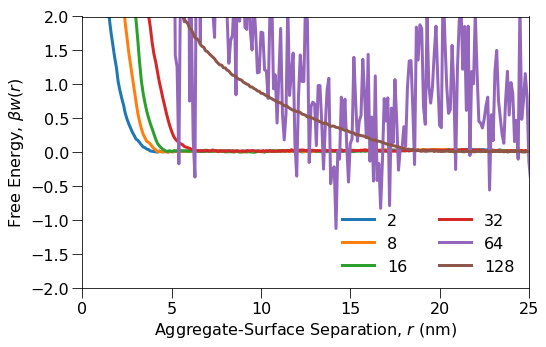

In [342]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data['$n.s.$'].items(): # at 0.25 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf'], label=str(N), lw=3)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.ylim((-2,2))
plt.xlim(0,25)
plt.show()

7.0 453.0
14.0 453.0
20.0 453.0
22.0 453.0
23.0 453.0
23.0 453.0


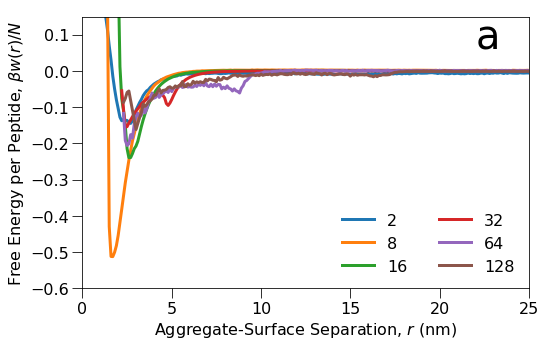

In [1033]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['2BEG_17-42']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.1].items(): # at 0.25 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf']/N, label=str(N), lw=3)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy per Peptide, $\beta w(r)/N$')
plt.ylim((-.6,.15))
plt.xlim(0,25)
plt.text(22,.06,'a',fontsize=40)

10.0 299.0
7.0 299.0
10.0 299.0


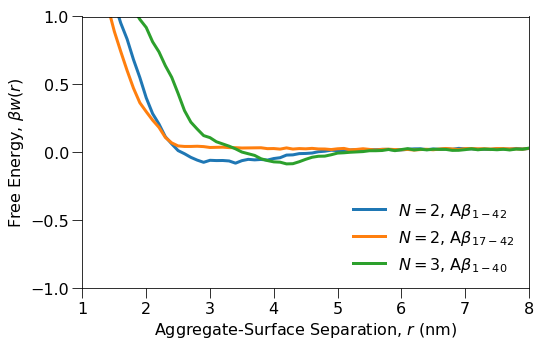

In [360]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

amyloids = [r'A$\beta_{1-42}$',r'A$\beta_{17-42}$',r'A$\beta_{1-40}$']

for name,amyloid in zip(['5KK3','2BEG_17-42','2M4J'],amyloids):
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.3].items(): # at 0.25 mol/l salt
        if N in [2,3]:#fibril['numpep_range']:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf'], label='$N=$'+str(N)+', '+amyloid, lw=3)
                
plt.yticks(np.arange(-1,1.1,0.5))
plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=1)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.ylim((-1,1))
plt.xlim(1,8)
plt.savefig('fig2a_response.eps')

17.0 299.0
13.0 299.0
20.0 299.0


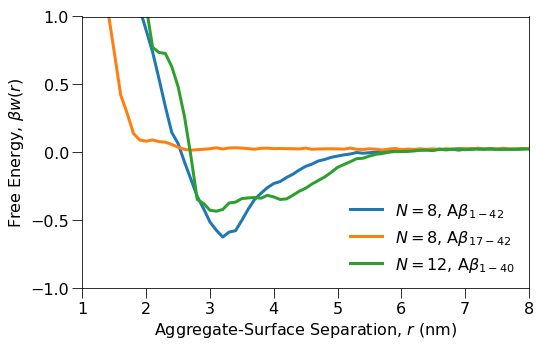

In [361]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

amyloids = [r'A$\beta_{1-42}$',r'A$\beta_{17-42}$',r'A$\beta_{1-40}$']

for name,amyloid in zip(['5KK3','2BEG_17-42','2M4J'],amyloids):
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.3].items(): # at 0.25 mol/l salt
        if N in [8,12]:#fibril['numpep_range']:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf'], label='$N=$'+str(N)+', '+amyloid, lw=3)
                
plt.yticks(np.arange(-1,1.1,0.5))
plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=1)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.ylim((-1,1))
plt.xlim(1,8)
plt.savefig('fig2b_response.eps')

16.0 299.0
25.0 299.0
27.0 299.0
29.0 299.0
32.0 299.0


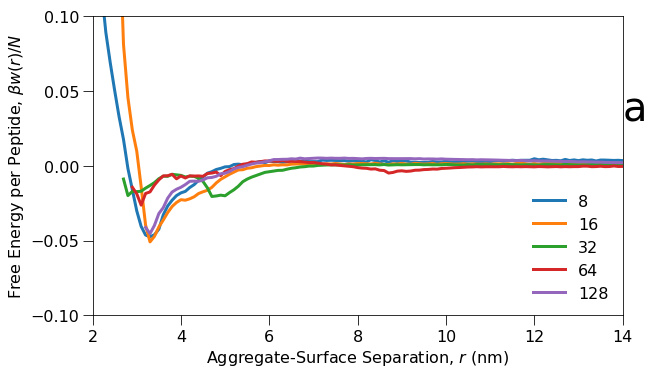

In [505]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [9.5, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.35].items(): # at 0.25 mol/l salt
        if N in [8,16,32,64,128]:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf']/N, label=str(N), lw=3)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=1)
plt.yticks(np.arange(-.1,.11,0.05))
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy per Peptide, $\beta w(r)/N$')
plt.ylim((-.1,.1))
plt.xlim(2,14)
plt.text(14,.03,'a',fontsize=40)
plt.savefig('fig4a_SM.eps')

10.0 299.0
17.0 299.0
25.0 299.0
27.0 299.0
28.0 299.0
32.0 299.0


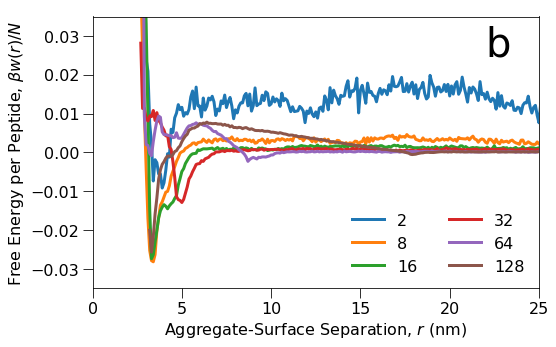

In [317]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.4].items(): # at 0.25 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf']/N, label=str(N), lw=3)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy per Peptide, $\beta w(r)/N$')
plt.ylim((-.035,.035))
plt.xlim(0,25)
plt.text(22,.025,'b',fontsize=40)

/lunarc/nobackup/users/gtesei00/AllFibrils_pf ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']


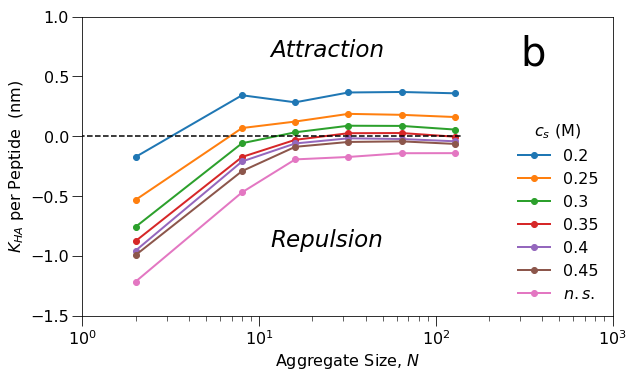

In [477]:
%cd -q $workdir

plt.rcParams.update({'font.size': 16, 'figure.figsize': [9.5, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for salt, d in data.iteritems():
        if str(salt) in ['0.2','0.25', '0.3', '0.35', '0.4','0.45','$n.s.$']:
            N = d.keys()    
            k = np.array( [ np.trapz( np.expm1(-i['pmf']/j), i['r']  ) for i,j in zip(d.get_values(),d.keys()) if type(i)==dict] )
            plt.plot(N, k*0.1, label=salt, linestyle='-', marker='o', lw=2, ms=6)

plt.plot( [0,140], [0,0], 'k--')
plt.legend(loc='lower right', frameon=False, fontsize='medium', title=r'$c_{s}$ (M)', ncol=1)        
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"$K_{HA}$ per Peptide  (nm)")
plt.xscale('log')
plt.figtext(0.4,0.78,'Attraction',rotation='0', color='k',fontsize='x-large', style='italic')
plt.figtext(0.4,0.3,'Repulsion',rotation='0',color='k',fontsize='x-large', style='italic')
plt.ylim((-1.5,1))
plt.xlim(1, 1000)
plt.text(300,0.6,'b',fontsize=40)
print(os.getcwd(),plt.rcParams["font.sans-serif"])
plt.savefig('fig4b_SM.eps')
plt.show()

10.0 299.0
17.0 299.0
25.0 299.0
27.0 299.0
29.0 299.0
32.0 299.0


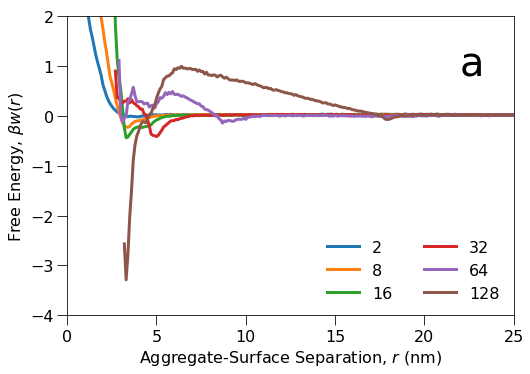

In [487]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.4].items(): # at 0.25 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf'], label=str(N), lw=3)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.ylim((-4,2))
plt.xlim(0,25)
plt.text(22,.8,'a',fontsize=40)
plt.savefig('fig2a.eps')

7.0 299.0
12.0 299.0
19.0 299.0
20.0 299.0
21.0 299.0
23.0 299.0


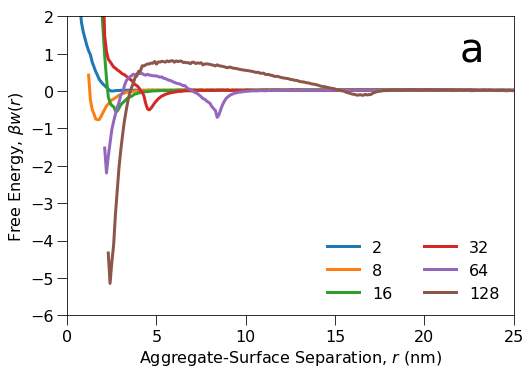

In [486]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['2BEG_17-42']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.2].items(): # at 0.25 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf'], label=str(N), lw=3)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.ylim((-6,2))
plt.xlim(0,25)
plt.text(22,.8,'a',fontsize=40)
plt.savefig('fig5a_SM.eps')

10.0 299.0
20.0 299.0
27.0 299.0
28.0 299.0
31.0 299.0
36.0 299.0


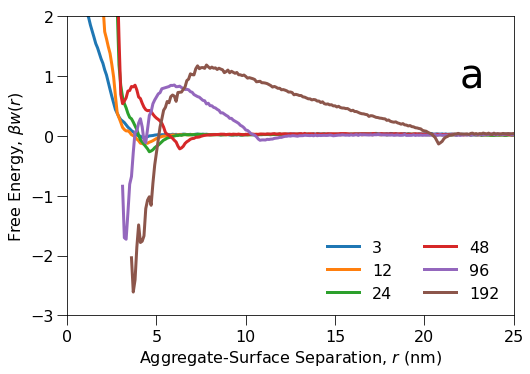

In [485]:
%cd -q $workdir

def find_first(y,y0):
    idx = np.argmin(y<y0)
    return idx

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['2M4J']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.4].items(): # at 0.25 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                print(d['r'][find_first(d['pmf'],10)],d['r'][-1])
                plt.plot( d['r']*0.1, d['pmf'], label=str(N), lw=3)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.ylim((-3,2))
plt.xlim(0,25)
plt.text(22,.8,'a',fontsize=40)
plt.savefig('fig6a_SM.eps')

### Surface Excess at Different Salt Concentrations and Fibril Lengths

Free energy profiles for aggregates of various $N$ interacting withh a neutral surface. Vertical black line show $s_0$ and $s_1$ used in the line segment model.

/lunarc/nobackup/users/gtesei00/AllFibrils_pf
/lunarc/nobackup/users/gtesei00/AllFibrils_pf ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']


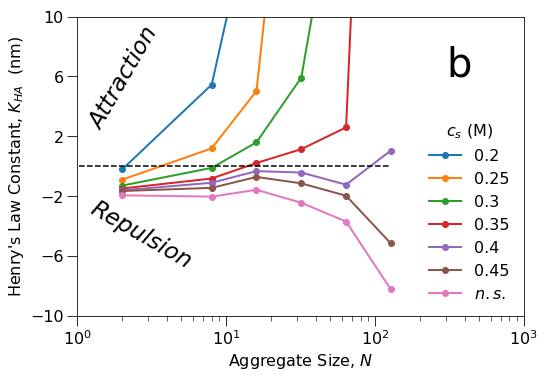

In [484]:
%cd -q $workdir
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
print(workdir)        

for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for salt, d in data.iteritems():
        if str(salt) in ['0.2', '0.25', '0.3', '0.35', '0.4', '0.45','$n.s.$']:
            N = d.keys()    
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )
            plt.plot(N, k*0.1, label=salt, linestyle='-', marker='o', lw=2, ms=6)
        
plt.plot( [0,128], [0,0], 'k--')
plt.legend(loc='lower right', frameon=False, fontsize='medium', title=r'$c_{s}$ (M)', ncol=1)        
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.xscale('log')
plt.figtext(0.14,0.82,'Attraction',rotation='60', color='k',fontsize='x-large', style='italic')
plt.figtext(0.14,0.38,'Repulsion',rotation='-30',color='k',fontsize='x-large', style='italic')
plt.ylim((-10,10))
plt.xlim(1, 1000)
plt.yticks(np.arange(-10,11,4))
plt.text(300,6,'b',fontsize=40)
print(os.getcwd(),plt.rcParams["font.sans-serif"])
plt.savefig('fig2b.eps')

/lunarc/nobackup/users/gtesei00/AllFibrils_pf
/lunarc/nobackup/users/gtesei00/AllFibrils_pf ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']


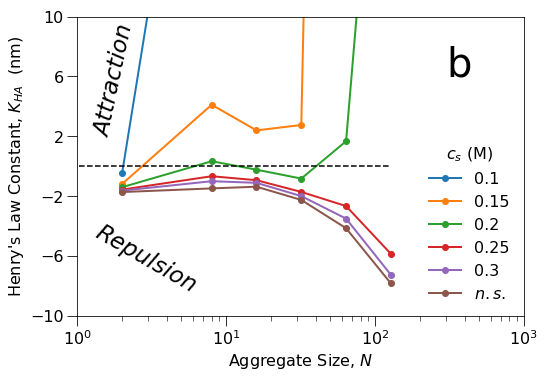

In [483]:
%cd -q $workdir
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
print(workdir)        

for name in ['2BEG_17-42']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for salt, d in data.iteritems():
        if str(salt) in ['0.1', '0.15', '0.2', '0.25', '0.3', '$n.s.$']:
            N = d.keys()    
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )
            plt.plot(N, k*0.1, label=salt, linestyle='-', marker='o', lw=2, ms=6)
        
plt.plot( [0,128], [0,0], 'k--')
plt.legend(loc='lower right', frameon=False, fontsize='medium', title=r'$c_{s}$ (M)', ncol=1)        
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.xscale('log')
plt.figtext(0.15,0.82,'Attraction',rotation='78', color='k',fontsize='x-large', style='italic')
plt.figtext(0.15,0.32,'Repulsion',rotation='-30',color='k',fontsize='x-large', style='italic')
plt.ylim((-10,10))
plt.xlim(1, 1000)
plt.yticks(np.arange(-10,11,4))
plt.text(300,6,'b',fontsize=40)
print(os.getcwd(),plt.rcParams["font.sans-serif"])
plt.savefig('fig5b_SM.eps')

/lunarc/nobackup/users/gtesei00/AllFibrils_pf
/lunarc/nobackup/users/gtesei00/AllFibrils_pf ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']


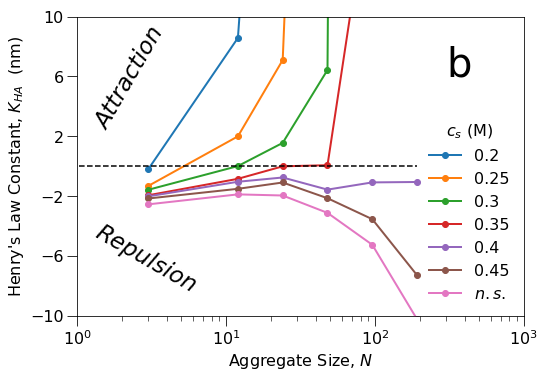

In [482]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
print(workdir)        

for name in ['2M4J']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for salt, d in data.iteritems():
        if str(salt) in ['0.2', '0.25', '0.3', '0.35', '0.4', '0.45','$n.s.$']:
            N = d.keys()    
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )
            plt.plot(N, k*0.1, label=salt, linestyle='-', marker='o', lw=2, ms=6)
        
plt.plot( [0,192], [0,0], 'k--')
plt.legend(loc='lower right', frameon=False, fontsize='medium', title=r'$c_{s}$ (M)', ncol=1)        
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.xscale('log')
plt.figtext(0.15,0.82,'Attraction',rotation='60', color='k',fontsize='x-large', style='italic')
plt.figtext(0.15,0.32,'Repulsion',rotation='-30',color='k',fontsize='x-large', style='italic')
plt.ylim((-10,10))
plt.xlim(1, 1000)
plt.yticks(np.arange(-10,11,4))
plt.text(300,6,'b',fontsize=40)
print(os.getcwd(),plt.rcParams["font.sans-serif"])
plt.savefig('fig6b_SM.eps')

## II. Line Segment Model

### II$a$. A$\beta_{17-42}$ peptides

Here we calculate the surface excess using a simplified model, considering Gouy-Chapman electrostatics and the excluded volume of a rod approaching a planar surface. As detailed in the main text, the free energy can be approximated with
$$
\beta w(r)^{\scriptsize{\mbox{rod}}} \approx  2 z \ln \left[ \frac{1+\tanh (\beta \phi e /4)e^{-\frac{r}{\lambda_D}}}{1-\tanh (\beta \phi e /4)e^{-\frac{r}{\lambda_D}}} \right] - \ln(2r/L) \vee 0
+ (s/r)^{9}
$$
and Henry's law constant is obtained from the following integral
$$
K_{HA} = \int_{0}^{\infty} dr \left [ \exp (-\beta w(r)) - 1 \right ].
$$
For A$\beta_{17-42}$ peptides, we set a net charge number per monomer of -1, and the lower and upper bounds of the distance of closest approach to 10 Å and 25 Å, respectively.

### II$b$. A$\beta_{1-40}$ peptides

Once we have proven that the line segment model is capable of capturing the physics undermining the adsorption of A$\beta_{17-42}$, we can apply the model to A$\beta_{1-40}$ peptides by setting net charge number per monomer equal to -3, and the lower and upper bounds of the distance of closest approach to 15 Å and 35 Å, respectively.

/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in true_divide


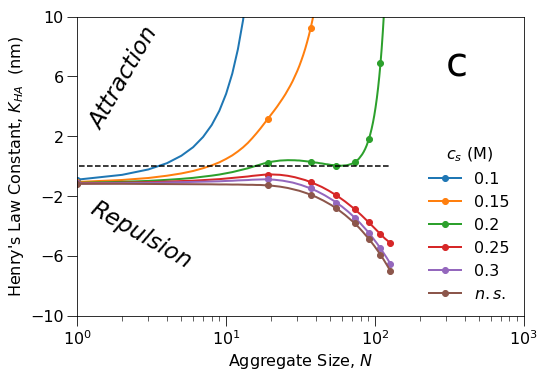

In [479]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
%cd -q $workdir
from math import asinh, sqrt, pi
lm=2.5    # monomer length (Å)
zm=-1     # monomer charge (e)
s0=15     # lower bound of the distance of closest approach (Å)
s1=25     # upper bound of the distance of closest approach (Å)
lB=7.1    # Bjerrum length (Å)
NA=6.022e23 # Avogadros number (1/mol)
sigma=1/266. # surface charge density (Å-2)
n = np.linspace(1, 128, 128) # number of monomers
salt = [0.1, 0.15, 0.2, 0.25, 0.3, 1e10] # salt concentrations

def find_nearest(y,y0):
    idx = (np.abs(y-y0)).argmin()
    return idx

def TdS(r, L):
    """ rod-2-surface excluded volume contribution to free energy (kT) """
    sel = r<0.5*L
    w   = -np.log(2*r[sel]/L)
    return np.concatenate((w, 0*r[~sel]))

# smooth function describing the dependece of the distance of closest approach on aggregate size
def dist(x,a,b,c,d):
    a = a 
    b = b - a
    return a + b/2. + b/2.*np.tanh((x-c)/d)

for cs in salt:
    Y = []
    X = []
    for N in n:               # number of monomers
        L = N*lm              # rod length (Å)
        z = zm*N              # rod charge (e)
        s = dist(N,s0,s1,10,60)
        lD = 3.04/sqrt(cs)    # Debye length (Å)
        phi = 2*asinh( sigma*sqrt(pi*lB/(2*cs*NA*1e-27)) ) # surf. potential (kT/e)
        r = np.arange(0, 1000, 0.1)
        # surface-line electrostatic interaction
        # eq 62. DOI: http://dx.doi.org/10.1016/S0006-3495(02)75375-7
        w = 2 * z * np.log( ( 1 + np.tanh( phi / 4. ) * np.exp(-r/lD) ) 
                         / ( 1 - np.tanh( phi / 4. ) * np.exp(-r/lD) ) ) + TdS(r,L) + (s/r)**9
        idx = find_nearest(w[:int(w.size/50)],1e3) # the integration starts where w = 1e3 kT
        r = r[idx:]
        w = w[idx:]
        # Henry's law constant
        k = np.trapz( np.expm1(-w), r )*.1
        Y.append(N)
        X.append(k)
    if cs == 1e10:
        cs = '$n.s.$'
    plt.plot(Y,X, label=cs, linestyle='-', marker='o', lw=2, ms=6, markevery = 18)
plt.plot( [0,128], [0,0], 'k--')
plt.legend(loc='lower right',frameon=False, fontsize='medium', title=r'$c_{s}$ (M)')
plt.ylim(-10,10)
plt.xlim(1,1000)
plt.figtext(0.14,0.82,'Attraction',rotation='60', color='k',fontsize='x-large', style='italic')
plt.figtext(0.14,0.38,'Repulsion',rotation='-30',color='k',fontsize='x-large', style='italic')
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.text(300,6,'c',fontsize=40)
plt.xscale('log')
plt.yticks(np.arange(-10,11,4))
plt.savefig('fig5c_SM.eps')
plt.show()

/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in true_divide


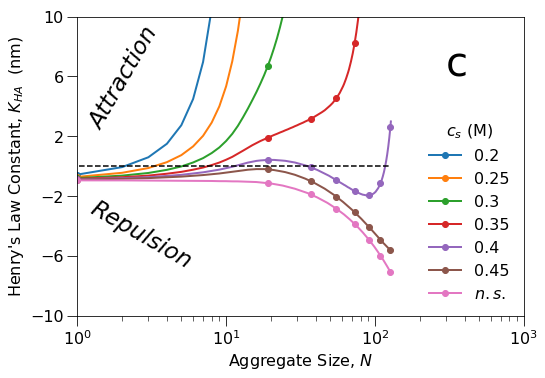

In [480]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
%cd -q $workdir
from math import asinh, sqrt, pi
lm=2.5    # monomer length (Å)
zm=-3     # monomer charge (e)
s0=10      # lower bound of the distance of closest approach (Å)
s1=23     # upper bound of the distance of closest approach (Å)
lB=7.1    # Bjerrum length (Å)
NA=6.022e23 # Avogadros number (1/mol)
sigma=1/266. # surface charge density (Å-2)
n = np.linspace(1, 128, 128) # number of monomers
salt = [0.2, 0.25, 0.3, .35, .4 ,.45,1e10] # salt concentrations

def find_nearest(y,y0):
    idx = (np.abs(y-y0)).argmin()
    return idx

def TdS(r, L):
    """ rod-2-surface excluded volume contribution to free energy (kT) """
    sel = r<0.5*L
    w   = -np.log(2*r[sel]/L)
    return np.concatenate((w, 0*r[~sel]))

# smooth function describing the dependece of the distance of closest approach on aggregate size
def dist(x,a,b,c,d):
    a = a 
    b = b - a
    return a + b/2. + b/2.*np.tanh((x-c)/d)

for cs in salt:
    Y = []
    X = []
    for N in n:               # number of monomers
        L = N*lm              # rod length (Å)
        z = zm*N              # rod charge (e)
        s = dist(N,s0,s1,10,60)
        lD = 3.04/sqrt(cs)    # Debye length (Å)
        phi = 2*asinh( 2*pi*sigma*lB*lD ) # surf. potential (kT/e)
        r = np.arange(0, 1000, 0.1)
        # surface-line electrostatic interaction
        # eq 62. DOI: http://dx.doi.org/10.1016/S0006-3495(02)75375-7
        w = 2 * z * np.log( ( 1 + np.tanh( phi / 4. ) * np.exp(-r/lD) ) 
                         / ( 1 - np.tanh( phi / 4. ) * np.exp(-r/lD) ) ) + TdS(r,L) + (s/r)**9
        idx = find_nearest(w[:int(w.size/50)],1e3) # the integration starts where w = 1e3 kT
        r = r[idx:]
        w = w[idx:]
        # Henry's law constant
        k = np.trapz( np.expm1(-w), r )*.1
        Y.append(N)
        X.append(k)
    if cs == 1e10:
        cs = '$n.s.$'
    plt.plot(Y,X, label=cs, linestyle='-', marker='o', lw=2, ms=6, markevery = 18)
plt.plot( [0,128], [0,0], 'k--')
plt.legend(loc='lower right',frameon=False, fontsize='medium', title=r'$c_{s}$ (M)')
plt.ylim(-10,10)
plt.xlim(1,1000)
plt.figtext(0.14,0.82,'Attraction',rotation='60', color='k',fontsize='x-large', style='italic')
plt.figtext(0.14,0.38,'Repulsion',rotation='-30',color='k',fontsize='x-large', style='italic')
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.text(300,6,'c',fontsize=40)
plt.yticks(np.arange(-10,11,4))
plt.xscale('log')
plt.savefig('fig2c.eps')
plt.show()

/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in true_divide


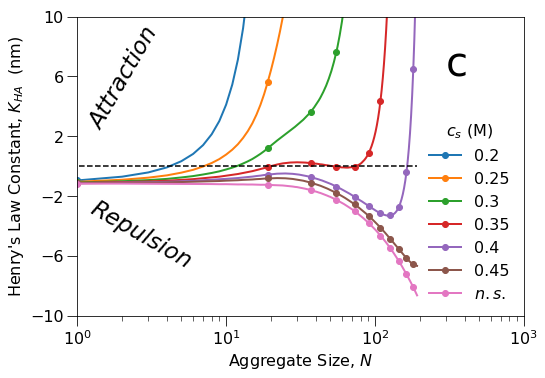

In [481]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 5.5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
%cd -q $workdir
from math import asinh, sqrt, pi
lm=2      # monomer length (Å)
zm=-3     # monomer charge (e)
s0=15      # lower bound of the distance of closest approach (Å)
s1=24.5     # upper bound of the distance of closest approach (Å)
lB=7.1    # Bjerrum length (Å)
NA=6.022e23 # Avogadros number (1/mol)
sigma=1/266. # surface charge density (Å-2)
n = np.linspace(1, 192, 192) # number of monomers
salt = [0.2, 0.25, 0.3, .35, .4 ,.45,1e10] # salt concentrations

for cs in salt:
    Y = []
    X = []
    for N in n:               # number of monomers
        L = N*lm              # rod length (Å)
        z = zm*N              # rod charge (e)
        s = dist(N,s0,s1,10,60)
        lD = 3.04/sqrt(cs)    # Debye length (Å)
        phi = 2*asinh( sigma*2*pi*lB*lD ) # surf. potential (kT/e)
        r = np.arange(0, 1000, 0.1)
        # surface-line electrostatic interaction
        # eq 62. DOI: http://dx.doi.org/10.1016/S0006-3495(02)75375-7
        w = 2 * z * np.log( ( 1 + np.tanh( phi / 4. ) * np.exp(-r/lD) ) 
                         / ( 1 - np.tanh( phi / 4. ) * np.exp(-r/lD) ) ) + TdS(r,L) + (s/r)**9
        idx = find_nearest(w[:int(w.size/50)],1e3) # the integration starts where w = 1e3 kT
        r = r[idx:]
        w = w[idx:]
        # Henry's law constant
        k = np.trapz( np.expm1(-w), r )*.1
        Y.append(N)
        X.append(k)
    if cs == 1e10:
        cs = '$n.s.$'
    plt.plot(Y,X, label=cs, linestyle='-', marker='o', lw=2, ms=6, markevery = 18)
plt.plot( [0,192], [0,0], 'k--')
plt.legend(loc='lower right',frameon=False, fontsize='medium', title=r'$c_{s}$ (M)')
plt.ylim(-10,10)
plt.xlim(1,1000)
plt.figtext(0.14,0.82,'Attraction',rotation='60', color='k',fontsize='x-large', style='italic')
plt.figtext(0.14,0.38,'Repulsion',rotation='-30',color='k',fontsize='x-large', style='italic')
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.text(300,6,'c',fontsize=40)
plt.yticks(np.arange(-10,11,4))
plt.xscale('log')
plt.savefig('fig6c_SM.eps')
plt.show()

### II$c$. Surface Excess of A$\beta_{1-40}$

The surface excess of the aggregates is given by the implicit equation
$$
\Gamma = K_{HA} \frac{\rho}{N} \left (1-\frac{2N\Gamma}{\sigma}\right )\exp \left (2\Gamma\hat{a}-\frac{2N\Gamma}{\sigma - 2N\Gamma} \right )
$$
where $\hat{a}$ is the mean-field energy constant for the adsorbed aggregates
$$
\hat{a} = - \frac{1}{2}\int_s^\infty dr 2\pi r \beta w(r)_{\scriptsize{\mbox{surface}}}.
$$

In [410]:
from pylab import cm, imshow, contour, clabel, colorbar
from scipy.optimize import brenth
from scipy.special import k0
def args(N, salt):
    L = N*lm              # rod length (Å)
    z = zm*N              # rod charge (e)
    lD = 3.04/sqrt(salt)  # Debye length (Å)
    s = dist(N,s0,s1,5,40)
    phi = 2*asinh( sigma*2*pi*lD*lB ) # surf. potential (kT/e)
    r = np.arange(s, 1000, 0.1)
    w_surf = 2*z*z*lB*k0(r/lD)/L + (s/r)**12
    a_hat = -pi*np.trapz( w_surf*r, r )*1e-2 
    r = np.arange(0, 1000, 0.1)
    w = 2 * z * np.log( ( 1 + np.tanh( phi / 4. ) * np.exp(-r/lD) ) 
                             / ( 1 - np.tanh( phi / 4. ) * np.exp(-r/lD) ) ) + TdS(r,L) + (s/r)**9
    idx = find_nearest(w[:int(w.size/50)],1e3)
    r = r[idx:]
    w = w[idx:]
    k = np.trapz( np.expm1(-w), r )*.1
    return (N,k,a_hat)
    
def exc(x,N,k,a_hat):    
    sigma = 100/266      # surface charge density (nm-2)
    return -x + k*rho/N*(1.-2*N*x/sigma)*np.exp(2*x*a_hat-2*N*x/(sigma-2*N*x))

x = np.linspace(0.05,0.5, 451) # salt concentration
y = np.linspace(1,250,250) # number of monomers
Z = np.ndarray(shape=(y.size,x.size))
rho = 2.4*1e-6     # conc of the bulk solution (nm-3)
for N in y:                   # number of monomers
    for salt in x:            # ionic strength (mol/l)
        b = brenth(exc, a=-1e-5, b=100, args=args(N, salt),maxiter=200)
        Z[y.tolist().index(N)][x.tolist().index(salt)] = b*1e3

/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in exp
/lunarc/nobackup/users/gtesei00/miniconda/envs/giulio/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in double_scalars


max: 6.12783838778 | min: -0.00189967133785


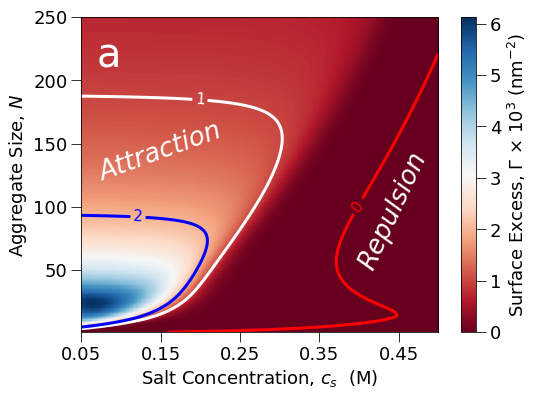

In [421]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8.0, 5.8]})

vmin=Z.min()
vmax=Z.max()
print('max:',Z.max(),'| min:',Z.min())

im = imshow(Z,cmap=cm.RdBu,extent=[x.min(),x.max(),y.min(),y.max()],origin='lower',aspect='auto', vmin=vmin, vmax=vmax) 

# contour lines
cset = contour(x, y, Z, [0,1,2], linewidths=3, cmap=cm.bwr_r)
manual_locations = [(0.12, 60),(0.2, 190),(0.4, 100)]
clabel(cset, inline=True, fmt='%1.f', fontsize=15, manual=manual_locations)

plt.figtext(0.15,0.59,'Attraction',rotation='20', color='white',fontsize='x-large', style='italic')
plt.figtext(0.6,0.52,'Repulsion',rotation='65',color='white',fontsize='x-large', style='italic')

# labels
colorbar(im,ticks=np.arange(0,6.5,1),label=r'Surface Excess, $\Gamma$ $\times$ 10$^3$ (nm$^{-2}$)') # adding the colorbar on the right
plt.ylabel('Aggregate Size, $N$')
plt.xlabel('Salt Concentration, $c_s$  (M)')
plt.xticks(np.arange(.05,.52,.1))
plt.text(0.07,210,'a',fontsize=40,color='w')
plt.xlim(.05,.5)
plt.savefig('fig3a.eps')
plt.show()

### II$d$. Adsorbed Amount of A$\beta_{1-40}$

The surface excess of the aggregates is converted into adsorbed amount:
$$
\Delta m = N \Gamma M_W / N_A
$$
where $M_W$ is the molecular weight of the A$\beta_{1-40}$ peptide.

In [412]:
x = np.linspace(0.05,0.5, 451) # salt concentration
y = np.linspace(1,250,250) # number of monomers
M = np.ndarray(shape=(y.size,x.size))
mass50mM = np.empty(0)
mass200mM = np.empty(0)
mass250mM = np.empty(0)
rho = 2.4*1e-6     # conc of the bulk solution (nm-3)
for N in y:                   # number of monomers
    for salt in x:            # ionic strength (mol/l)
        c = N*4.3298/6.022
        M[y.tolist().index(N)][x.tolist().index(salt)] = Z[y.tolist().index(N)][x.tolist().index(salt)]*c
        if salt==0.05:
            mass50mM = np.append( mass50mM, Z[y.tolist().index(N)][x.tolist().index(salt)]*c )
        if salt==0.2:
            mass200mM = np.append( mass200mM, Z[y.tolist().index(N)][x.tolist().index(salt)]*c )
        if salt==0.25:
            mass250mM = np.append( mass250mM, Z[y.tolist().index(N)][x.tolist().index(salt)]*c )

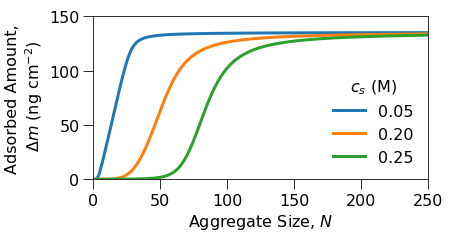

In [478]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 3.0]})

plt.plot(y,mass50mM, label='0.05', linestyle='-', lw=3)
plt.plot(y,mass200mM, label='0.20', linestyle='-', lw=3)
plt.plot(y,mass250mM, label='0.25', linestyle='-', lw=3)
plt.xlim(0,250)
plt.ylim(0,150)
plt.xlabel('Aggregate Size, $N$')
plt.ylabel('Adsorbed Amount,\n $\Delta m$ (ng cm$^{-2}$)')
plt.legend(loc='lower right',frameon=False, fontsize='medium', title=r'$c_{s}$ (M)')
#plt.tight_layout()
plt.savefig('fig3_SM.pdf', bbox_inches='tight', pad_inches=0.3)
plt.show()

max: 134.920042702 | min: -0.0134222200467


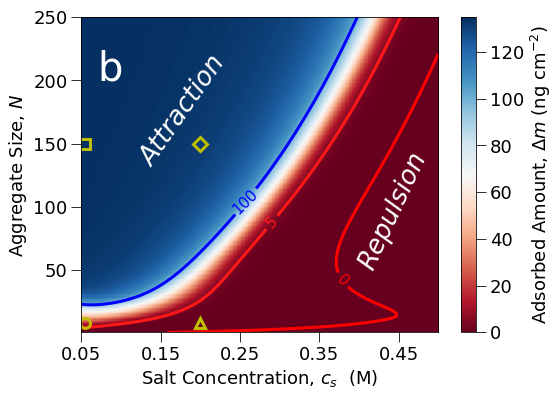

In [420]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8.0, 5.8]})

vmin=M.min()
vmax=M.max()
print('max:',M.max(),'| min:',M.min())

im = imshow(M,cmap=cm.RdBu,extent=[x.min(),x.max(),y.min(),y.max()],origin='lower',aspect='auto', vmin=vmin, vmax=vmax) 

# contour lines
cset = contour(x, y, M, [0,5,100], linewidths=3, cmap=cm.bwr_r)
manual_locations = [(0.25, 110),(0.3, 80),(0.37, 35)]
clabel(cset, inline=True, fmt='%1.f', fontsize=15, manual=manual_locations)

plt.figtext(0.22,0.75,'Attraction',rotation='55', color='white',fontsize='x-large', style='italic')
plt.figtext(0.6,0.52,'Repulsion',rotation='65',color='white',fontsize='x-large', style='italic')
#plt.scatter([.05,.2,.05,.2], [150,150,1,1], s=500, c='k', alpha=0,edgecolors='k')
plt.plot( [.055], [150], 's', ms=10, mew=3, mec='y', mfc='None')
plt.plot( [.2], [150], 'D', ms=10, mew=3, mec='y', mfc='None')
plt.plot( [.055], [8], 'o', ms=10, mew=3, mec='y', mfc='None')
plt.plot( [.2], [8], '^', ms=10, mew=3, mec='y', mfc='None')
# labels
colorbar(im,ticks=np.arange(0,135,20),label=r'Adsorbed Amount, $\Delta m$ (ng cm$^{-2}$)') # adding the colorbar on the right
plt.ylabel('Aggregate Size, $N$')
plt.xlabel('Salt Concentration, $c_s$  (M)')
plt.xticks(np.arange(.05,.52,.1))
plt.text(0.07,200,'b',fontsize=40,color='w')
plt.xlim(.05,.5)
plt.ylim(1,250)
plt.savefig('fig3b.eps')
plt.show()

### II$e$. Comparison with QCM-D results

Here the surface excess values estimated by the model are converted to Hz to facilitate the comparison with QCM-D experiments. 

In [ ]:
for i in [0,150]:
    print('salt concentration (M):',x[i])
    print('aggregate size:',y[149])
    print('surface excess (nm):',Z[149][i])
    print('adsorbed amount (ng cm-2):',M[149][i])
    print('DF/n (Hz):',M[149][i]/17.7)
    print('------------------------')
print('Ratio between surface excess values, for N=150, at ionic strengths of 50 mM and 200 mM:')
print(Z[149][0]/Z[149][150])

## III. Quartz Crystal Microbalance Dissipation (QCM-D)

In this section we load and plot QCM data.

In [498]:
F50mon = np.loadtxt('exp/50mon.dat',comments={'T'},usecols=(0,1,3,5))
D50mon = np.loadtxt('exp/50mon.dat',comments={'T'},usecols=(0,2,4,6))

F200fib = np.loadtxt('exp/200fib.dat',comments={'T'},usecols=(0,3,5,7))
D200fib = np.loadtxt('exp/200fib.dat',comments={'T'},usecols=(0,4,6,8))

F200mon = np.loadtxt('exp/200mon.dat',comments={'T'},usecols=(0,1,3,5))
D200mon = np.loadtxt('exp/200mon.dat',comments={'T'},usecols=(0,2,4,6))

F50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,1,5,9,13))
D50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,3,7,11,15))
Fit50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,2,4,6,8,10,12,14,16))
vis50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,17,20,23))
shear50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,18,21,24))
mass50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,19,22,25))

F50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,1,5,9,13))
D50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,3,7,11,15))
Fit50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,2,4,6,8,10,12,14,16))
vis50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,17,20,23))
shear50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,18,21,24))
mass50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,19,22,25))

mass50fib[:,1:] = mass50fib[:,1:]/100
vis50fib[:,1:] = vis50fib[:,1:]
shear50fib[:,1:] = shear50fib[:,1:]/100

mass50fib2[:,1:] = mass50fib2[:,1:]/100
vis50fib2[:,1:] = vis50fib2[:,1:]
shear50fib2[:,1:] = shear50fib2[:,1:]/100

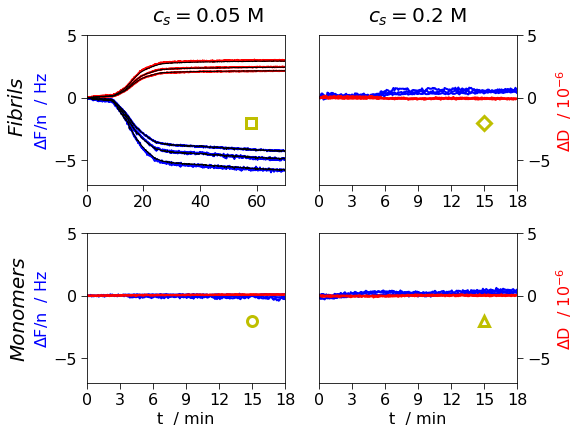

In [877]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6], 
                     'xtick.minor.size':3, 'xtick.major.size':6, 'ytick.minor.size':3, 'ytick.major.size':6})
f = plt.figure()

xticks = np.arange(0,19,3)

# 50 mM fibrils
ax = f.add_subplot(221)
plt.ylim(-7,5)
ax.text(-28,0.5,'Fibrils',rotation=90,fontsize=20, style='italic')
ax.text(23,6,'$c_s = 0.05$ M',fontsize=20)
plt.xlim(0,70)
plt.ylabel("$\Delta$F/n  / Hz",color='blue')
plt.plot(F50fib[:,0]/60,F50fib[:,2:],color='blue', lw=2)
plt.plot(D50fib[:,0]/60,D50fib[:,2:],color='red', lw=2)
plt.plot(Fit50fib[:,0]/60,Fit50fib[:,3:],color='black', lw=1)
plt.plot( [58], [-2], 's', ms=10, mew=3, mec='y', mfc='None')

# 200 mM fibrils
ax = f.add_subplot(222)
plt.xticks(xticks)
ax.text(4.5,6,'$c_s = 0.2$ M',fontsize=20)
ax.yaxis.tick_right()
plt.ylim(-7,5)
plt.xlim(0,18)
plt.ylabel("$\Delta$D  / 10$^{-6}$",color='red')
ax.yaxis.set_label_position("right")
plt.plot(F200fib[:,0]/60,F200fib[:,1:],color='blue', lw=2)
plt.plot(D200fib[:,0]/60,D200fib[:,1:],color='red', lw=2)
plt.plot( [15], [-2], 'D', ms=10, mew=3, mec='y', mfc='None')

# 50 mM monomers
ax = f.add_subplot(223)
plt.xticks(xticks)
ax.text(-7,2,'Monomers',rotation=90,fontsize=20, style='italic')
plt.ylim(-7,5)
plt.xlim(0,18)
plt.ylabel("$\Delta$F/n  / Hz",color='blue')
plt.xlabel("t  / min")
plt.plot(F50mon[:,0]/60,F50mon[:,1:],color='blue', lw=2)
plt.plot(D50mon[:,0]/60,D50mon[:,1:],color='red', lw=2)
plt.plot( [15], [-2], 'o', ms=10, mew=3, mec='y', mfc='None')

# 200 mM monomers
ax = f.add_subplot(224)
plt.xticks(xticks)
ax.yaxis.tick_right()
plt.ylim(-7,5)
plt.xlim(0,18)
plt.ylabel("$\Delta$D  / 10$^{-6}$",color='red')
ax.yaxis.set_label_position("right")
plt.xlabel("t  / min")
plt.plot(F200mon[:,0]/60,F200mon[:,1:],color='blue', lw=2)
plt.plot(D200mon[:,0]/60,D200mon[:,1:],color='red', lw=2)
plt.plot( [15], [-2], '^', ms=10, mew=3, mec='y', mfc='None')

f.tight_layout()
f.savefig('fig4.eps', bbox_inches='tight', pad_inches=0.3)
plt.show()

### III$a$. Analysis of QCM-D data for different batches of sonicated fibrils

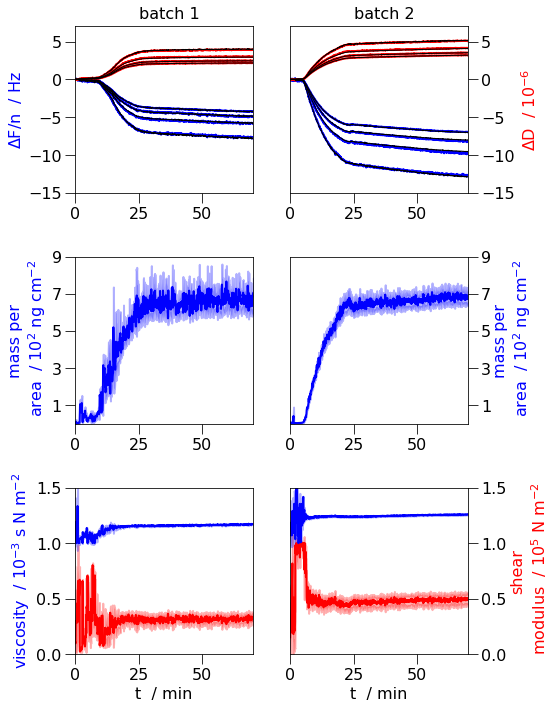

In [898]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 10.0]})
f = plt.figure()

xticks = np.arange(0,19,3)

# 50 mM fibrils, batch 1
ax = f.add_subplot(321)
plt.ylim(-15,7)
ax.text(25,8,'batch 1',fontsize=16)
plt.xlim(0,70)
plt.ylabel("$\Delta$F/n  / Hz",color='blue')
plt.plot(F50fib[1:,0]/60,F50fib[1:,1:],color='blue', lw=2)
plt.plot(D50fib[1:,0]/60,D50fib[1:,1:],color='red', lw=2)
plt.plot(Fit50fib[1:,0]/60,Fit50fib[1:,1:],color='black', lw=1)

# 50 mM fibrils, batch 2
ax = f.add_subplot(322)
ax.text(25,8,'batch 2',fontsize=16)
ax.yaxis.tick_right()
plt.ylim(-15,7)
plt.xlim(0,70)
plt.ylabel("$\Delta$D  / 10$^{-6}$",color='red')
ax.yaxis.set_label_position("right")
plt.plot(F50fib2[1:,0]/60,F50fib2[1:,1:],color='blue', lw=2)
plt.plot(D50fib2[1:,0]/60,D50fib2[1:,1:],color='red', lw=2)
plt.plot(Fit50fib2[1:,0]/60,Fit50fib2[1:,1:],color='black', lw=1)

# mass per area and shear modulus, batch 1
ax = f.add_subplot(323)
plt.yticks(np.arange(1,10,2))
plt.ylim(0,9)
plt.xlim(0,70)
plt.ylabel("mass per\n area  / 10$^2$ ng cm$^{-2}$",color='blue')
plt.plot(mass50fib[:,0]/60,
          mass50fib[:,1:].mean(axis=1),color='blue',lw=2)
plt.fill_between(mass50fib[:,0]/60,
          mass50fib[:,1:].mean(axis=1)
        + mass50fib[:,1:].std(axis=1),
          mass50fib[:,1:].mean(axis=1)
        - mass50fib[:,1:].std(axis=1),color='blue',lw=2,alpha=.3)

# mass per area and shear modulus, batch 2
ax = f.add_subplot(324)
plt.yticks(np.arange(1,10,2))
ax.yaxis.tick_right()
plt.ylim(0,9)
plt.xlim(0,70)
plt.ylabel("mass per\n area  / 10$^2$ ng cm$^{-2}$",color='blue')
ax.yaxis.set_label_position("right")
plt.plot(mass50fib2[:,0]/60,
          mass50fib2[:,1:].mean(axis=1),color='blue',lw=2)
plt.fill_between(mass50fib2[:,0]/60,
          mass50fib2[:,1:].mean(axis=1)
        + mass50fib2[:,1:].std(axis=1),
          mass50fib2[:,1:].mean(axis=1)
        - mass50fib2[:,1:].std(axis=1),color='blue',lw=2,alpha=.3)

# mass per area and shear modulus, batch 1
ax = f.add_subplot(325)
plt.yticks(np.arange(0,2,0.5))
plt.ylim(0,1.5)
plt.xlim(0,70)
plt.ylabel("viscosity  / 10$^{-3}$ s N m$^{-2}$",color='blue')
plt.xlabel("t  / min")
plt.plot(shear50fib[:,0]/60,
          shear50fib[:,1:].mean(axis=1),color='red', lw=2)
plt.fill_between(shear50fib[:,0]/60,
          shear50fib[:,1:].mean(axis=1)
        + shear50fib[:,1:].std(axis=1),
          shear50fib[:,1:].mean(axis=1)
        - shear50fib[:,1:].std(axis=1),color='red',lw=2,alpha=.3)
plt.plot(vis50fib[:,0]/60,
          vis50fib[:,1:].mean(axis=1),color='blue',lw=2)
plt.fill_between(vis50fib[:,0]/60,
          vis50fib[:,1:].mean(axis=1)
        + vis50fib[:,1:].std(axis=1),
          vis50fib[:,1:].mean(axis=1)
        - vis50fib[:,1:].std(axis=1),color='blue',lw=2,alpha=.3)

# mass per area and shear modulus, batch 2
ax = f.add_subplot(326)
plt.yticks(np.arange(0,2,0.5))
ax.yaxis.tick_right()
plt.ylim(0,1.5)
plt.xlim(0,70)
plt.ylabel("shear\n modulus  / 10$^{5}$ N m$^{-2}$",color='red',size=16)
ax.yaxis.set_label_position("right")
plt.xlabel("t  / min")
plt.plot(shear50fib2[:,0]/60,
          shear50fib2[:,1:].mean(axis=1),color='red', lw=2)
plt.fill_between(shear50fib2[:,0]/60,
          shear50fib2[:,1:].mean(axis=1)
        + shear50fib2[:,1:].std(axis=1),
          shear50fib2[:,1:].mean(axis=1)
        - shear50fib2[:,1:].std(axis=1),color='red',lw=2,alpha=.3)
plt.plot(vis50fib2[:,0]/60,
          vis50fib2[:,1:].mean(axis=1),color='blue',lw=2)
plt.fill_between(vis50fib2[:,0]/60,
          vis50fib2[:,1:].mean(axis=1)
        + vis50fib2[:,1:].std(axis=1),
          vis50fib2[:,1:].mean(axis=1)
        - vis50fib2[:,1:].std(axis=1),color='blue',lw=2,alpha=.3)

f.tight_layout()
f.savefig('fig2_SM.pdf', bbox_inches='tight', pad_inches=0.3)
plt.show()

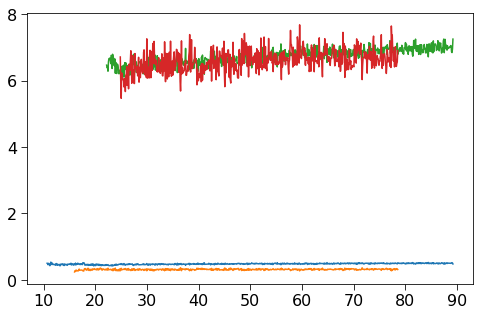

In [577]:
plt.plot(shear50fib2[120:,0]/60,
          shear50fib2[120:,1:].mean(axis=1))
plt.plot(shear50fib[180:,0]/60,
          shear50fib[180:,1:].mean(axis=1))
plt.plot(mass50fib2[250:,0]/60,
          mass50fib2[250:,1:].mean(axis=1))
plt.plot(mass50fib[280:,0]/60,
          mass50fib[280:,1:].mean(axis=1))

In [571]:
print(shear50fib2[120:,1:].mean(axis=1).mean(),shear50fib2[120:,1:].mean(axis=1).std())
print(shear50fib[180:,1:].mean(axis=1).mean(),shear50fib[180:,1:].mean(axis=1).std())

0.481751159522 0.0191478677504
0.314425711888 0.0173319537915


In [572]:
print(vis50fib2[120:,1:].mean(axis=1).mean(),vis50fib2[120:,1:].mean(axis=1).std())
print(vis50fib[180:,1:].mean(axis=1).mean(),vis50fib[180:,1:].mean(axis=1).std())

1.24984974142 0.00792839319428
1.16153326067 0.00722647439657


In [578]:
print(mass50fib2[250:,1:].mean(axis=1).mean(),mass50fib2[250:,1:].mean(axis=1).std())
print(mass50fib[280:,1:].mean(axis=1).mean(),mass50fib[280:,1:].mean(axis=1).std())

6.72693220275 0.224581082754
6.58895149962 0.32780165708
